# This project is still in work. Isn't ready to be read. Yes, they warned me: that making this public a no turning back decision

In the past, I've done some models using several libraries in Python without really understanding what I was doing. I want to implement multiple learning models, using less -or **none**- *pre-made* ML resources. I hope this will be reflected in a  deeper understanding on what each learning model does.

This time, I'll be implementing **Linear regression** in Python.

I'll be using `pandas` to import and process data sets, `numpy` to get useful linear algebra functions, and `pyplot` to make **really cute** graphics. Just take a look. Yeah... they're cute, aren't they?

## First, let's load our libraries.

In [84]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [85]:
# import dataframe
df = pd.read_csv('../input/kc_house_data.csv')

# Convert date column from string to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT%H%M%S')
# Aaaand... convert that datetime to integer (days elapsed since lowest date in column)
df['date'] =  (df['date'] - df['date'].min())  / np.timedelta64(1,'D')

## Create train and validation set

In [86]:
train = df.sample(frac=0.8)
test = df.drop(train.index)

## Create prediction target and feature matrix

In [87]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

By looking at column names, I can say that `'id'` and `'price'` will conform `'y_train'` and `'y_test'`, my prediction target.

Let's stablish that:

In [88]:
pred_target = ['id', 'price']

I'm pretty skeptical that `'date'`, `'zipcode'`, `'lat'`,  or `'long'` are correlated to the price of the house. But I'll decide that later. For now, I'll assume everything **could** influence `'price'`, so `X_train` and `X_test`, my feature matrices, will be conformed by the whole dataframe, without `'id'` and `'price'`.

Let's create `y_train`, `y_test`, `X_train`, and `X_test` matrices:

In [89]:
y_train = train[pred_target]
X_train = train.drop(pred_target, axis=1)

y_test = test[pred_target]
X_test = test.drop(pred_target, axis=1)

From here, we will only work with the training sets. Until the very end, that we test our model to verify it's correctnes. 

### Find Correlations

We will now calculate the correlation ratio between `X_train` and `y_train['price']`

In [90]:
corr = X_train.corrwith(y_train['price'])
corr = corr.to_frame().transpose().rename({0:'price'})
corr

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,-0.005859,0.307412,0.527357,0.70392,0.089476,0.260026,0.266284,0.392921,0.039513,0.66935,0.60779,0.326099,0.059854,0.12312,-0.05201,0.305495,0.022141,0.582005,0.080681


Now we must decide which features actually influence house price.

In Perason's association, coefficients between .10 and .29 represent a small association, coefficients between .30 and .49 represents a medium association, and coefficients above .50, a large association.

We'll generate two models:
1. Using features only with large associations.
2. Using features with medium and large associations.

So, let's choose our features.

We could do it manually, but we are not any grandma! Let's write some code to do it:

In [91]:
# create a tuple (string, float) list with (column names, values) of the corr dataframe
corr_temp = list(zip(corr.columns.values.tolist(), corr.iloc[0,:].tolist()))

# sort a tuple list, created by applying one condition on each
corr_above50 = sorted([t for t in corr_temp if t[1]>.5], key=lambda t: t[1])
corr_above30 = sorted([t for t in corr_temp if t[1]>.3], key=lambda t: t[1])

# 
print ("Features with correlation bigger than .3:")
for feature in corr_above30:
    print ("\t", feature)
print ("Features with correlation bigger than .5:")
for feature in corr_above50:
    print ("\t", feature)

Features with correlation bigger than .3:
	 ('lat', 0.30549527158841794)
	 ('bedrooms', 0.3074123282909124)
	 ('sqft_basement', 0.3260994982865726)
	 ('view', 0.3929214852711809)
	 ('bathrooms', 0.5273572359570723)
	 ('sqft_living15', 0.5820052711723428)
	 ('sqft_above', 0.6077901534949522)
	 ('grade', 0.6693502955704209)
	 ('sqft_living', 0.7039202110847222)
Features with correlation bigger than .5:
	 ('bathrooms', 0.5273572359570723)
	 ('sqft_living15', 0.5820052711723428)
	 ('sqft_above', 0.6077901534949522)
	 ('grade', 0.6693502955704209)
	 ('sqft_living', 0.7039202110847222)


Yey! We got the features we wanted. Let's plot them, I want to see something pretty, or I'll go nuts.

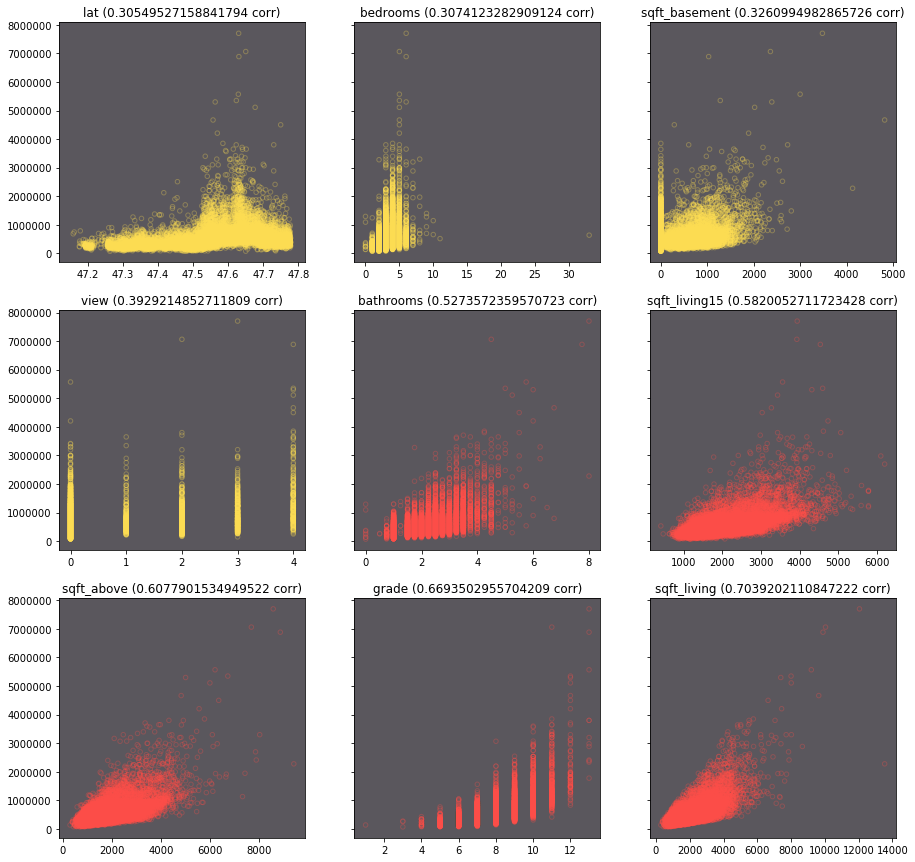

In [106]:
alpha = .3   # alpha of scatter plot markers
edgecolor1 = '#FFDF52'    # color of 'above30' marker borders
edgecolor2 = '#FF4D48'    # color of 'above50' marker borders
color = 'none'    # fill color of marker borders
background = '#5A575D'    # background color for all plots
grid = '#68646B'    # grid color for all plots

# other colors: FFDF52 (cute yellow), FF4D48 (cute red), 4FC1BB (cute blue)

plot_rows = int(np.ceil(np.sqrt(len(corr_above30))))
plot_cols = int(np.floor(np.sqrt(len(corr_above30))))

if(plot_rows*plot_cols < len(corr_above30)): plot_cols = plot_cols + 1
fig, axarr = plt.subplots(plot_rows, plot_cols, figsize = (15,15))
for i in range (plot_rows):
    for j in range (plot_cols):
        edgecolors = edgecolor1 if ((i*(plot_cols) + j) < len(corr_above30) - len(corr_above50)) else edgecolor2
        if((i*(plot_cols) + j) >= len(corr_above30)): break
        axarr[i, j].scatter(X_train[corr_above30[i * (plot_cols) + j][0]], y_train['price'],
                            alpha = alpha, s = 20, c = color,
                            edgecolors=edgecolors);
        axarr[i, j].set_title (corr_above30[i * (plot_cols) + j][0] +
                               " (" + str(corr_above30[i * (plot_cols) + j][1]) + " corr)")
        axarr[i, j].patch.set_facecolor(background)
        if (j>0): (plt.setp(axarr[i, j].get_yticklabels(), visible=False))
            
for i in range(plot_rows*plot_cols-len(corr_above30)):
    axarr[-1, -(i+1)].axis('off')
    
plt.show()

The graphs above, use all the features with medium or large association. The values in that *red-like* color, are the features with large association.

We will use all that features to create `X_train_m`, and all the *red-like* ones to create `X_train_l`:

In [110]:
X_train_m = X_train[[t[0] for t in corr_above30]]
X_train_l = X_train[[t[0] for t in corr_above50]]

And, for sake of curiosity, let's create `X_train_w`, containing **all** the features in the dataset. (We will just copy it, to let `X_train` free of mutation.

In [111]:
X_train_w = X_train.copy()

Just because, we will normalize **all** features in both `X_m` and `X_l`!

To normalize, we have to implement this mathematical model:

$$
x_{i}:=\dfrac{x_{i}−\mu_{i}}{s_{i}}
$$

In [120]:
# X is the feature matrix to be normalized
def normalize(X):
    X_norm = X[:]    # copy feature matrix
    mu = []          # median matrix
    sigma = []       # std matrix
    for i in range(X.shape[1]):
        mu.append(X_norm.iloc[:,i].mean())        # append median of (arr[i]th) column
        sigma.append(X_norm.iloc[:,i].std())      # append std of (arr[i]th)column
        # normalize (arr[i]th) column
        X_norm.iloc[:,i] = (X_norm.iloc[:,i] - mu[i]) / sigma[i]
    return mu, sigma, X_norm

# mu list contains median of all normalized columns
# sigma list contains std of all normalized columns
# X_norm is X matrix normalized
[mu_m, sigma_m, X_train_m_norm] = normalize(X_train_m)
[mu_l, sigma_l, X_train_l_norm] = normalize(X_train_l)
[mu_w, sigma_w, X_train_w_norm] = normalize(X_train_w)

Now we modify `X_m_norm` and `X_l_norm`, adding the intercept term -a *ghost* feature with all values = 1-.

In [122]:
X_train_m_norm.insert(0, 'intercept', 1)
X_train_l_norm.insert(0, 'intercept', 1)
X_train_w_norm.insert(0, 'intercept', 1)

It's great so far. Now, lets stablish `alpha` -the learning rate-, `iters` -the number of iterations-, and `theta`s -theta vectors for each model-.

In [126]:
alpha = .1
iters = 100
theta_l = [0] * len(X_train_l_norm.columns)
theta_m = [0] * len(X_train_m_norm.columns)
theta_w = [0] * len(X_train_w_norm.columns)

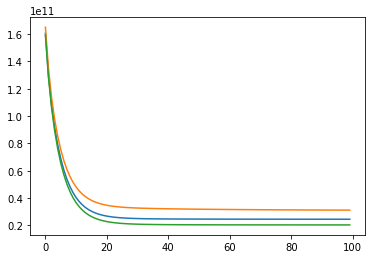

In [139]:
def computeCost(X, y, theta):
    return (X.dot(theta)).subtract(y['price']).pow(2).sum() / (2 * len(y))

def gradientDescent(X, y, theta, alpha, iters):
    m = len(y)
    J_history = []
    for i in range(iters):
        error = (X.dot(theta)).subtract(y['price']);
        for j in range(len(theta)):
            theta[j] = theta[j]-(alpha * error.multiply(X.iloc[:,j]).sum())/m;
            
        J_history.append(computeCost(X, y, theta));
    return theta, J_history

alpha = .1
iters = 100

theta_l = [0] * len(X_train_l_norm.columns)
theta_m = [0] * len(X_train_m_norm.columns)
theta_w = [0] * len(X_train_w_norm.columns)

[theta_l, J_history_l] = gradientDescent(X_train_l_norm, y_train, theta_l, alpha, iters)
[theta_m, J_history_m] = gradientDescent(X_train_m_norm, y_train, theta_m, alpha, iters)
[theta_w, J_history_w] = gradientDescent(X_train_w_norm, y_train, theta_w, alpha, iters)

plt.plot(J_history_m)
plt.plot(J_history_l)
plt.plot(J_history_w);

In [134]:
print("m error: ", J_history_m[-1])
print("l error: ", J_history_l[-1])
print("w error: ", J_history_w[-1])

m error:  24487832118.03299
l error:  31143824002.510098
w error:  20319808702.68345


Well, those error values are **pretty** big.  Let's calculate the validation error.

But first, we must normalize `X_test`, but not with the same method, but by subtracting `mu` and then dividing by `sigma`.

In [164]:
X_test_m = (X_test[X_train_m.columns] - mu_m) / sigma_m
X_test_l = (X_test[X_train_l.columns] - mu_l) / sigma_l
X_test_w = (X_test - mu_w) / sigma_w

And add the `intercept` feature!

In [169]:
X_test_m.insert(0, 'intercept', 1)
X_test_l.insert(0, 'intercept', 1)
X_test_w.insert(0, 'intercept', 1)

Let's compute the validation error now!

In [172]:
print("m validation error: ", computeCost(X_test_m, y_test, theta_m))
print("l validation error:   ", computeCost(X_test_l, y_test, theta_l))
print("w validation error: ", computeCost(X_test_w, y_test, theta_w))

m validation error:  9669605104615.06
l validation error:    31017911777.017925
w validation error:  3349356088015.7524
